<a href="https://colab.research.google.com/github/Safinaz-Muhammad/Task-1--Medical-Images-Segmentation/blob/main/Lungs_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Git if not already installed
!apt-get install git -qq

# Configure Git with your info
!git config --global user.email "safinazmo7amed@gmail.com.com"
!git config --global user.name "Safinaz-Muhammad"

# Clone your GitHub repo (only once)
!git clone https://github.com/Safinaz-Muhammad/Task-1--Medical-Images-Segmentation

Cloning into 'Task-1--Medical-Images-Segmentation'...
remote: Enumerating objects: 501, done.
remote: Counting objects: 100% (501/501), done.
remote: Compressing objects: 100% (487/487), done.
remote: Total 501 (delta 14), reused 501 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (501/501), 23.79 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
 from google.colab import files
files.upload()  # upload kaggle.json here

# ========================
# 1. Setup Kaggle API
# ========================
!mkdir -p ~/.kaggle/ # Create the .kaggle directory if it doesn't exist
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ========================
# 2. Download + unzip datasets
# ========================
!mkdir -p ./datasets/lungs ./datasets/liver ./datasets/heart

# Lungs CT dataset
!kaggle datasets download -d kmader/finding-lungs-in-ct-data -p ./datasets/lungs --unzip

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data
License(s): unknown
 98% 1.01G/1.03G [00:11<00:00, 96.8MB/s]
100% 1.03G/1.03G [00:11<00:00, 94.7MB/s]


In [ ]:
# ========================
# 3. Common imports
# ========================
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import nibabel as nib # Import nibabel for .nii files

In [ ]:
# ========================
# 4. Preprocessing functions
# ========================
def load_and_preprocess_pil(image_path, target_size=(128,128)):
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize(target_size)
        return np.array(img) / 255.0
    except Exception as e:
        print(f"Error loading and preprocessing image {image_path}: {e}")
        return None

def load_and_preprocess_mask_pil(mask_path, target_size=(128,128)):
    try:
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize(target_size, Image.NEAREST)
        mask = np.array(mask)
        return (mask > 0).astype(np.uint8)
    except Exception as e:
        print(f"Error loading and preprocessing mask {mask_path}: {e}")
        return None

# ========================
# 5. Dataset loader (generic)
# ========================
def load_dataset(dataset_name):
    """
    dataset_name: "lungs", "liver", or "heart"
    """
    base_path = f"./datasets/{dataset_name}"

    # Depending on dataset, find images and masks
    if dataset_name == "lungs":
        img_dir = os.path.join(base_path, "2d_images")
        mask_dir = os.path.join(base_path, "2d_masks")
        image_extensions = (".png", ".jpg", ".tif")
        mask_extensions = (".png", ".jpg", ".tif")
    elif dataset_name == "liver":
        img_dir = os.path.join(base_path, "images")
        mask_dir = os.path.join(base_path, "annotation")
        image_extensions = (".png", ".jpg")
        mask_extensions = (".png", ".jpg")
    elif dataset_name == "heart":
        img_dir = os.path.join(base_path, "images")
        mask_dir = os.path.join(base_path, "data")
        image_extensions = (".png", ".jpg")
        mask_extensions = (".png", ".jpg")
    else:
        raise ValueError("Unknown dataset")

    # List all image files
    image_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(image_extensions)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(mask_extensions)])


    print(f"Found {len(image_files)} image files and {len(mask_files)} mask files in {dataset_name} dataset.")

    images, masks = [], []
    for img_path, mask_path in zip(image_files, mask_files):
        img = load_and_preprocess_pil(img_path)
        mask = load_and_preprocess_mask_pil(mask_path)
        if img is not None and mask is not None:
            images.append(img)
            masks.append(mask)
        else:
            print(f"Skipping {img_path} and {mask_path} due to loading or preprocessing errors.")


    images = np.array(images)
    masks = np.expand_dims(np.array(masks), -1)
    print(f"{dataset_name} dataset loaded: {images.shape[0]} samples")
    return images, masks

In [ ]:
# ========================
# 6. Load a dataset (example: lungs)
# ========================
X, y = load_dataset("lungs")

# ========================
# 7. Train/Validation split
# ========================
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================
# 8. Metrics & compilation
# ========================
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(tf.cast(tf.squeeze(y_true, -1), tf.int32), depth=2)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_score(y_true, y_pred, smooth=1):
    y_true = tf.one_hot(tf.cast(tf.squeeze(y_true, -1), tf.int32), depth=2)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def compile_model(model):
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", dice_coefficient, iou_score]
    )
    return model

Found 267 image files and 267 mask files in lungs dataset.
lungs dataset loaded: 267 samples


In [ ]:
!ls ./datasets/lungs/2d_images
!ls ./datasets/lungs/2d_masks

ID_0000_Z_0142.tif  ID_0067_Z_0238.tif	ID_0134_Z_0137.tif  ID_0201_Z_0241.tif
ID_0001_Z_0146.tif  ID_0068_Z_0055.tif	ID_0135_Z_0066.tif  ID_0202_Z_0098.tif
ID_0002_Z_0162.tif  ID_0069_Z_0054.tif	ID_0136_Z_0122.tif  ID_0203_Z_0079.tif
ID_0003_Z_0132.tif  ID_0070_Z_0120.tif	ID_0137_Z_0155.tif  ID_0204_Z_0066.tif
ID_0004_Z_0066.tif  ID_0071_Z_0072.tif	ID_0138_Z_0063.tif  ID_0205_Z_0066.tif
ID_0005_Z_0066.tif  ID_0072_Z_0119.tif	ID_0139_Z_0056.tif  ID_0206_Z_0062.tif
ID_0006_Z_0206.tif  ID_0073_Z_0076.tif	ID_0140_Z_0230.tif  ID_0207_Z_0160.tif
ID_0007_Z_0211.tif  ID_0074_Z_0066.tif	ID_0141_Z_0128.tif  ID_0208_Z_0063.tif
ID_0008_Z_0065.tif  ID_0075_Z_0061.tif	ID_0142_Z_0145.tif  ID_0209_Z_0267.tif
ID_0009_Z_0114.tif  ID_0076_Z_0230.tif	ID_0143_Z_0124.tif  ID_0210_Z_0140.tif
ID_0010_Z_0259.tif  ID_0077_Z_0173.tif	ID_0144_Z_0224.tif  ID_0211_Z_0140.tif
ID_0011_Z_0156.tif  ID_0078_Z_0058.tif	ID_0145_Z_0059.tif  ID_0212_Z_0064.tif
ID_0012_Z_0167.tif  ID_0079_Z_0072.tif	ID_0146_Z_0122.tif  ID_02

In [ ]:
!ls ./datasets/lungs
!

2d_images      2d_masks      3d_images	    lung_stats.csv
2d_images.zip  2d_masks.zip  3d_images.zip


In [ ]:
# ========================
# 9. Models (U-Net example)
# ========================
def simple_unet(input_size=(128,128,3), num_classes=2):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    b = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)

    u2 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(b)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)

    u1 = layers.Conv2DTranspose(16, 2, strides=2, padding="same")(c3)
    u1 = layers.concatenate([u1, c1])
    c4 = layers.Conv2D(16, 3, activation="relu", padding="same")(u1)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c4)
    return models.Model(inputs, outputs)

# ========================
# 10. Train the model
# ========================
model = compile_model(simple_unet(input_size=X_train.shape[1:], num_classes=2))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=4)


Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step - accuracy: 0.7465 - dice_coefficient: 0.5827 - iou_score: 0.4142 - loss: 0.5963 - val_accuracy: 0.8306 - val_dice_coefficient: 0.7325 - val_iou_score: 0.5782 - val_loss: 0.4169
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.8458 - dice_coefficient: 0.7556 - iou_score: 0.6082 - loss: 0.3766 - val_accuracy: 0.9125 - val_dice_coefficient: 0.8466 - val_iou_score: 0.7343 - val_loss: 0.2279
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - accuracy: 0.9111 - dice_coefficient: 0.8594 - iou_score: 0.7550 - loss: 0.2290 - val_accuracy: 0.9473 - val_dice_coefficient: 0.9142 - val_iou_score: 0.8425 - val_loss: 0.1425
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 361ms/step - accuracy: 0.9426 - dice_coefficient: 0.9117 - iou_score: 0.8388 - loss: 0.1493 - val_accuracy: 0.9363 - val_dice_coefficient: 0.9144 - val_iou_score: 0.8430 - val_loss: 0.1750
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - accuracy: 0.9487 - dice_co

In [ ]:
# ========================
# 11. Visualize predictions
# ========================
def visualize_predictions(model, X, y, num=3):
    preds = model.predict(X[:num])
    preds_classes = np.argmax(preds, axis=-1)
    for i in range(num):
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1); plt.imshow(X[i]); plt.title("Image")
        plt.subplot(1,3,2); plt.imshow(y[i].squeeze()); plt.title("Ground Truth")
        plt.subplot(1,3,3); plt.imshow(preds_classes[i]); plt.title("Prediction")
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


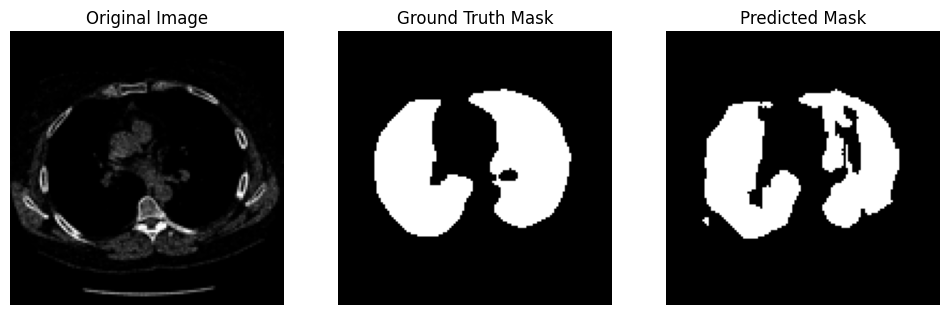

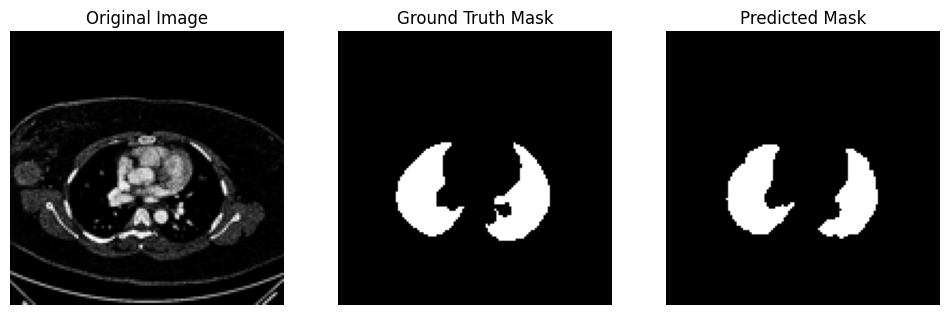

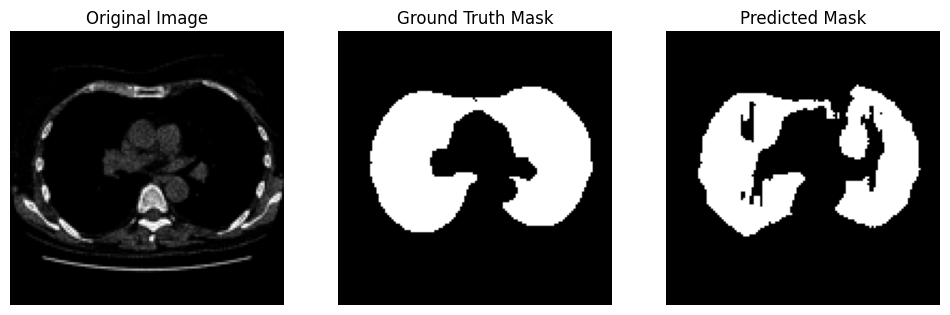

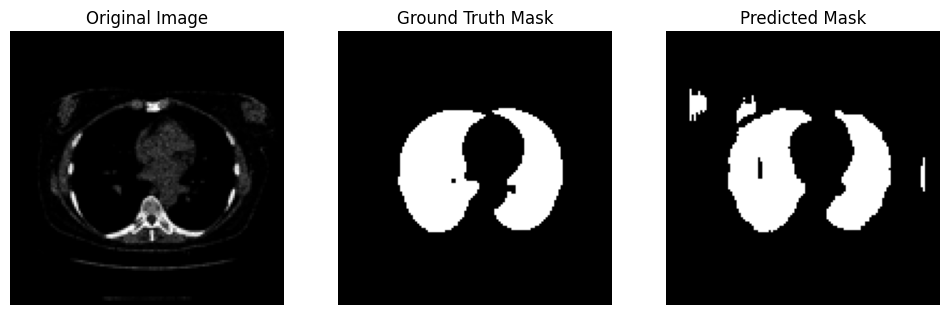

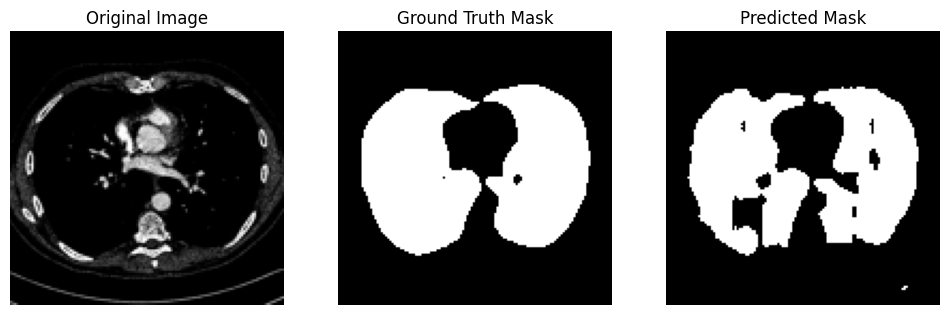

In [ ]:
import numpy as np
def visualize_lungs_predictions(model, X, y, num_samples=5):
    """
    Display original image, ground truth mask, and predicted mask for lungs.
    """
    preds = model.predict(X[:num_samples])
    preds_classes = np.argmax(preds, axis=-1)  # shape: (num_samples, H, W)

    for i in range(num_samples):
        plt.figure(figsize=(12,4))

        # Original CT image
        plt.subplot(1,3,1)
        plt.imshow(X[i])
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1,3,2)
        plt.imshow(y[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1,3,3)
        plt.imshow(preds_classes[i], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# ========================
# Usage example
# ========================
visualize_lungs_predictions(model, X_val, y_val, num_samples=5)



Found 267 image files and 267 mask files in lungs dataset.
lungs dataset loaded: 267 samples


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 2)    │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,778 (2.82 MB)

 Trainable params: 739,778 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 963ms/step - accuracy: 0.7534 - loss: 0.5595 - val_accuracy: 0.8612 - val_loss: 0.3302
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 846ms/step - accuracy: 0.8799 - loss: 0.2933 - val_accuracy: 0.9109 - val_loss: 0.2326
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 779ms/step - accuracy: 0.9142 - loss: 0.2096 - val_accuracy: 0.7996 - val_loss: 0.3955
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 845ms/step - accuracy: 0.8950 - loss: 0.2468 - val_accuracy: 0.9407 - val_loss: 0.1662
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 808ms/step - accuracy: 0.9360 - loss: 0.1613 - val_accuracy: 0.9375 - val_loss: 0.1668
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


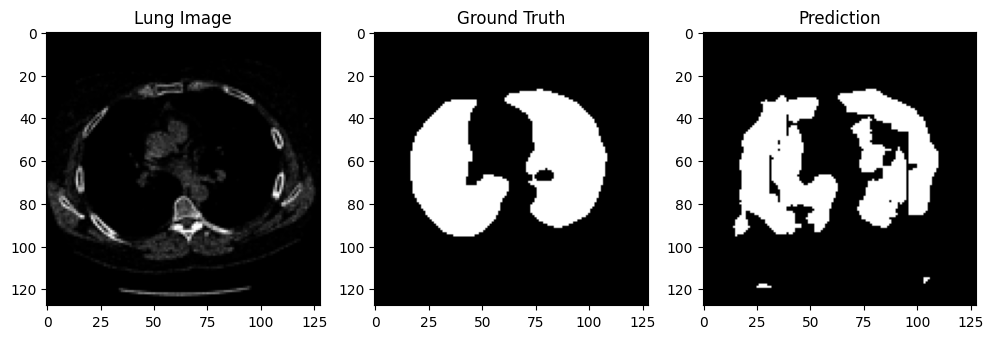

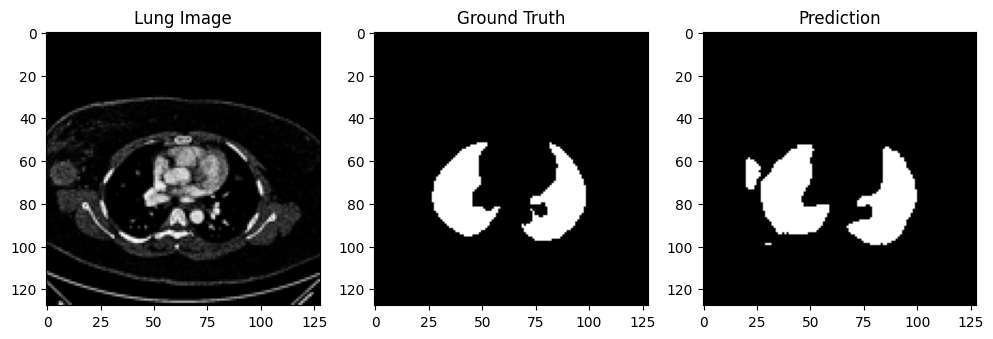

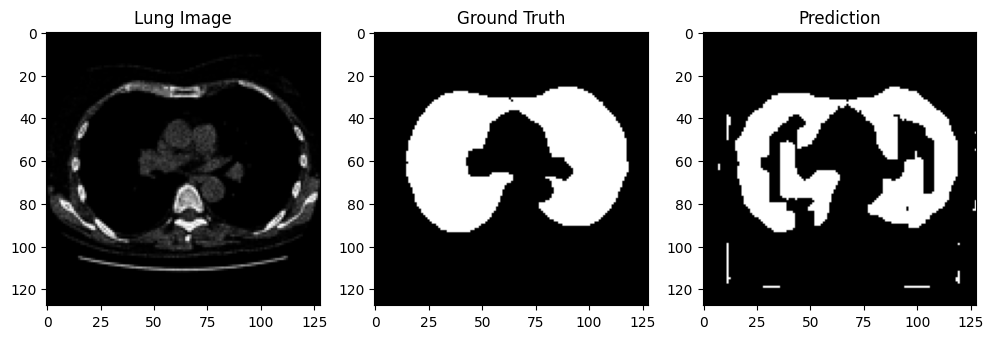

In [ ]:
# ========================
# 1️⃣ Import libraries
# ========================
import os
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.ndimage import label
from tensorflow.keras.metrics import Precision, Recall # Import Precision and Recall

# ========================
# 2️⃣ Load lung dataset
# ========================
# Assume you have X_lungs, y_lungs loaded already
# X_lungs: (N,H,W,3), y_lungs: (N,H,W,1) with 0=background,1=lung

# Load the lungs dataset into X and y
X, y = load_dataset("lungs")


# Example split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================
# 3️⃣ Build SegNet model
# ========================
def simple_segnet(input_size=(128,128,3), num_classes=2):
    inputs = layers.Input(input_size)

    # Encoder
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # Decoder
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)
    return models.Model(inputs, outputs)

# ========================
# 4️⃣ Compile model
# ========================
segnet_lungs = simple_segnet(input_size=X_train.shape[1:], num_classes=2)
segnet_lungs.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"] # Removed Precision and Recall
)
segnet_lungs.summary()

# ========================
# 5️⃣ Train model
# ========================
history = segnet_lungs.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=4
)

# ========================
# 6️⃣ Evaluate predictions
# ========================
preds = segnet_lungs.predict(X_val)
preds_classes = np.argmax(preds, axis=-1)  # (N,H,W)

# Visualize a few 2D predictions
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(X_val[i]); plt.title("Lung Image")
    plt.subplot(1,3,2); plt.imshow(y_val[i].squeeze(), cmap='gray'); plt.title("Ground Truth")
    plt.subplot(1,3,3); plt.imshow(preds_classes[i], cmap='gray'); plt.title("Prediction")
    plt.show()



Found 267 image files and 267 mask files in lungs dataset.
lungs dataset loaded: 267 samples


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 2)    │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,778 (2.82 MB)

 Trainable params: 739,778 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 837ms/step - accuracy: 0.7598 - loss: 0.5661 - val_accuracy: 0.8536 - val_loss: 0.3448
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 801ms/step - accuracy: 0.8712 - loss: 0.3179 - val_accuracy: 0.9051 - val_loss: 0.2280
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 858ms/step - accuracy: 0.8973 - loss: 0.2387 - val_accuracy: 0.9210 - val_loss: 0.1946
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 839ms/step - accuracy: 0.9287 - loss: 0.1779 - val_accuracy: 0.9131 - val_loss: 0.2140
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 941ms/step - accuracy: 0.9366 - loss: 0.1589 - val_accuracy: 0.9416 - val_loss: 0.1549


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


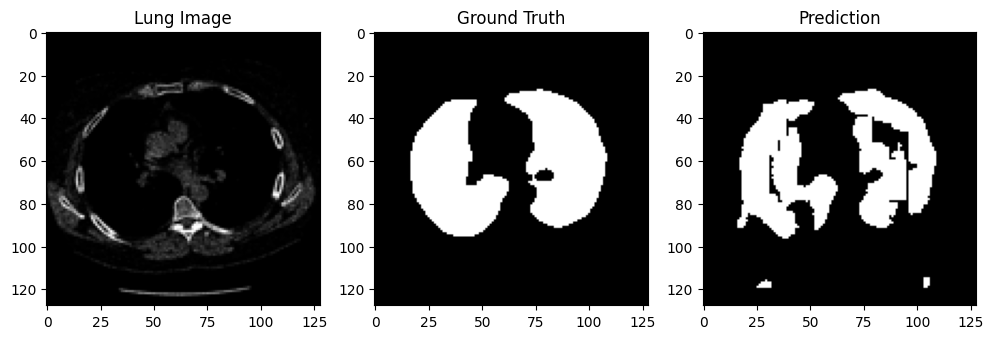

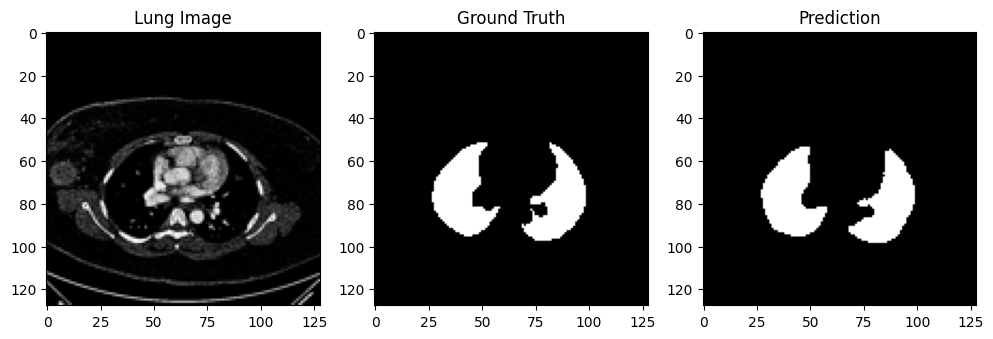

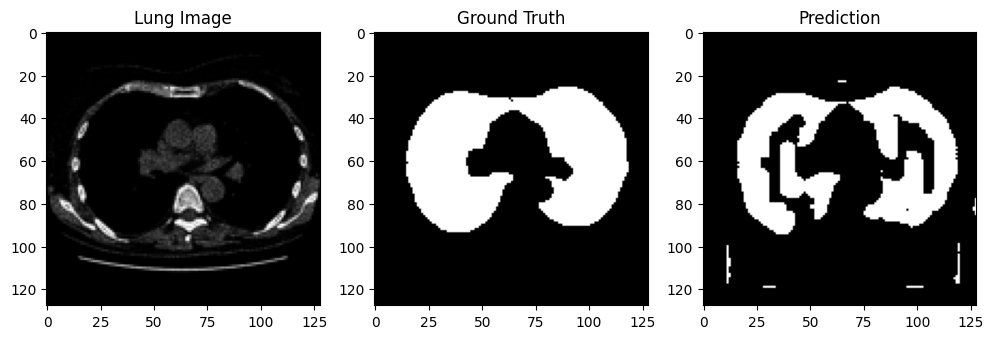

In [ ]:
# ========================
# 1️⃣ Import libraries
# ========================
import os
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.ndimage import label
from tensorflow.keras.metrics import Precision, Recall # Import Precision and Recall

# ========================
# 2️⃣ Load lung dataset
# ========================
# Assume you have X_lungs, y_lungs loaded already
# X_lungs: (N,H,W,3), y_lungs: (N,H,W,1) with 0=background,1=lung

# Load the lungs dataset into X and y
X, y = load_dataset("lungs")


# Example split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================
# 3️⃣ Build SegNet model
# ========================
def simple_segnet(input_size=(128,128,3), num_classes=2):
    inputs = layers.Input(input_size)

    # Encoder
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # Decoder
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)
    return models.Model(inputs, outputs)

# ========================
# 4️⃣ Compile model
# ========================
segnet_lungs = simple_segnet(input_size=X_train.shape[1:], num_classes=2)
segnet_lungs.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"] # Removed Precision and Recall
)
segnet_lungs.summary()

# ========================
# 5️⃣ Train model
# ========================
history = segnet_lungs.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=4
)

# ========================
# 6️⃣ Evaluate predictions
# ========================
preds = segnet_lungs.predict(X_val)
preds_classes = np.argmax(preds, axis=-1)  # (N,H,W)

# Visualize a few 2D predictions
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(X_val[i]); plt.title("Lung Image")
    plt.subplot(1,3,2); plt.imshow(y_val[i].squeeze(), cmap='gray'); plt.title("Ground Truth")
    plt.subplot(1,3,3); plt.imshow(preds_classes[i], cmap='gray'); plt.title("Prediction")
    plt.show()



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling_with_a… │ [(None, 64, 64,   │          0 │ conv2d_26[0][0]   │
│ (MaxPoolingWithArg… │ 64), (None, 64,   │            │                   │
│                     │ 64, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling_with… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling_with_a… │ [(None, 32, 32,   │          0 │ conv2d_27[0][0]   │
│ (MaxPoolingWithArg… │ 128), (None, 32,  │            │                   │
│                     │ 32, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling_with… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling_with_a… │ [(None, 16, 16,   │          0 │ conv2d_28[0][0]   │
│ (MaxPoolingWithArg… │ 256), (None, 16,  │            │                   │
│                     │ 16, 256)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_unpooling2d_2   │ (None, 32, 32,    │          0 │ max_pooling_with… │
│ (MaxUnpooling2D)    │ 256)              │            │ max_pooling_with… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │    295,040 │ max_unpooling2d_… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_unpooling2d_3   │ (None, 64, 64,    │          0 │ conv2d_29[0][0],  │
│ (MaxUnpooling2D)    │ 128)              │            │ max_pooling_with… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │     73,792 │ max_unpooling2d_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_unpooling2d_4   │ (None, 128, 128,  │          0 │ conv2d_30[0][0],  │
│ (MaxUnpooling2D)    │ 64)               │            │ max_pooling_with… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │     36,928 │ max_unpooling2d_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 128, 128,  │        130 │ conv2d_31[0][0]   │
│                     │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 776,706 (2.96 MB)

 Trainable params: 776,706 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5010 - val_loss: 0.6931
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.5005 - val_loss: 0.6931
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4997 - val_loss: 0.6932
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.5005 - val_loss: 0.6932
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5009 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


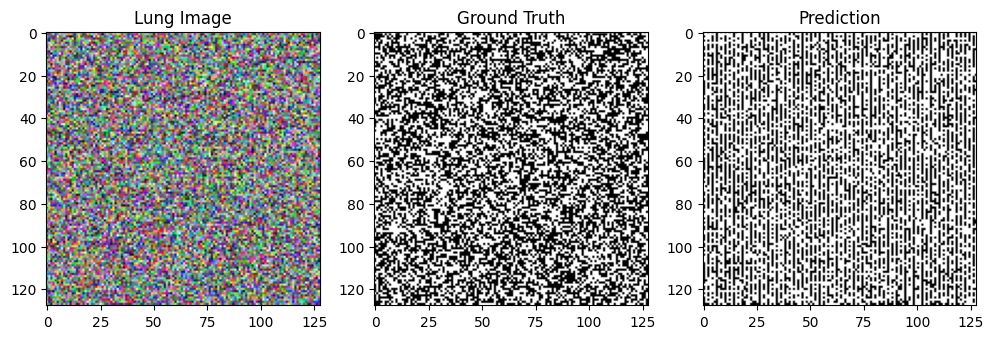

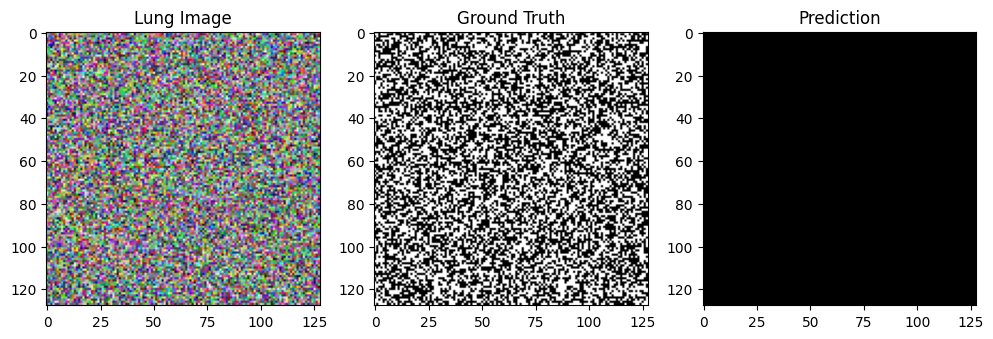

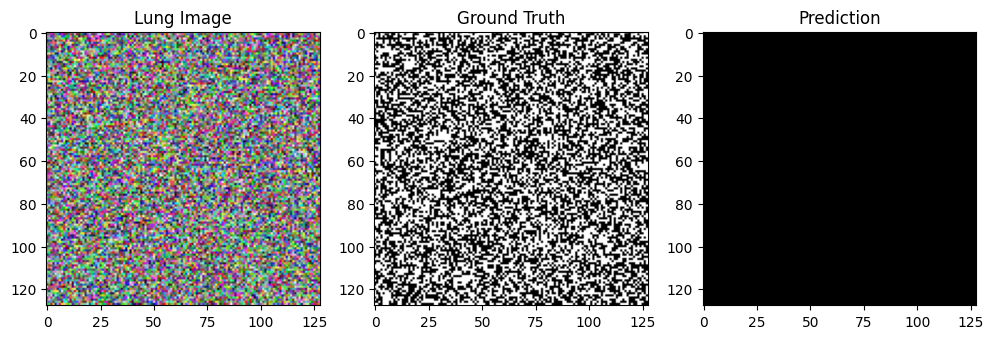

In [ ]:
# ========================
# 1️⃣ Import libraries
# ========================
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ========================
# 2️⃣ Load lung dataset
# ========================
# Replace with your real dataset loading
# X_lungs: (N,H,W,3), y_lungs: (N,H,W,1)
def load_dataset(name):
    # Dummy example for demonstration
    X = np.random.rand(50, 128, 128, 3)
    y = np.random.randint(0, 2, size=(50, 128, 128, 1))
    return X, y

X, y = load_dataset("lungs")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================
# 3️⃣ SegNet with pooling indices
# ========================
class MaxPoolingWithArgmax2D(layers.Layer):
    def __init__(self, pool_size=(2,2), strides=(2,2), **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs):
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=[1, self.pool_size[0], self.pool_size[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            padding='SAME',
            output_dtype=tf.dtypes.int64
        )
        return [output, argmax] # Return both output and argmax

class MaxUnpooling2D(layers.Layer):
    def __init__(self, pool_size=(2,2), **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        input_tensor, argmax = inputs # Receive both input tensor and argmax
        input_shape = tf.shape(input_tensor)
        output_shape = [input_shape[0], input_shape[1]*self.pool_size[0], input_shape[2]*self.pool_size[1], input_shape[3]]
        flat_input = tf.reshape(input_tensor, [-1])
        flat_output = tf.scatter_nd(tf.expand_dims(tf.reshape(argmax, [-1]),1), flat_input, [tf.reduce_prod(output_shape)])
        return tf.reshape(flat_output, output_shape)

def full_segnet(input_size=(128,128,3), num_classes=2):
    inputs = layers.Input(input_size)

    # Encoder
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    pool1, argmax1 = MaxPoolingWithArgmax2D()(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(pool1)
    pool2, argmax2 = MaxPoolingWithArgmax2D()(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(pool2)
    pool3, argmax3 = MaxPoolingWithArgmax2D()(x)

    # Decoder using unpooling
    x = MaxUnpooling2D()([pool3, argmax3])
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    x = MaxUnpooling2D()([x, argmax2])
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    x = MaxUnpooling2D()([x, argmax1])
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ========================
# 4️⃣ Compile model
# ========================
segnet = full_segnet(input_size=X_train.shape[1:], num_classes=2)
segnet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
segnet.summary()

# ========================
# 5️⃣ Train model
# ========================
history = segnet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=4
)

# ========================
# 6️⃣ Evaluate predictions
# ========================
preds = segnet.predict(X_val)
preds_classes = np.argmax(preds, axis=-1)

# Visualize a few predictions
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(X_val[i]); plt.title("Lung Image")
    plt.subplot(1,3,2); plt.imshow(y_val[i].squeeze(), cmap='gray'); plt.title("Ground Truth")
    plt.subplot(1,3,3); plt.imshow(preds_classes[i], cmap='gray'); plt.title("Prediction")
    plt.show()


Training History Metrics for Lungs U-Net:


,accuracy,loss,val_accuracy,val_loss
0,0.500027,0.693168,0.501050,0.693143
1,0.500394,0.693154,0.500476,0.693149
2,0.501241,0.693139,0.499701,0.693168
3,0.500647,0.693149,0.500488,0.693158
4,0.500700,0.693144,0.499982,0.693157


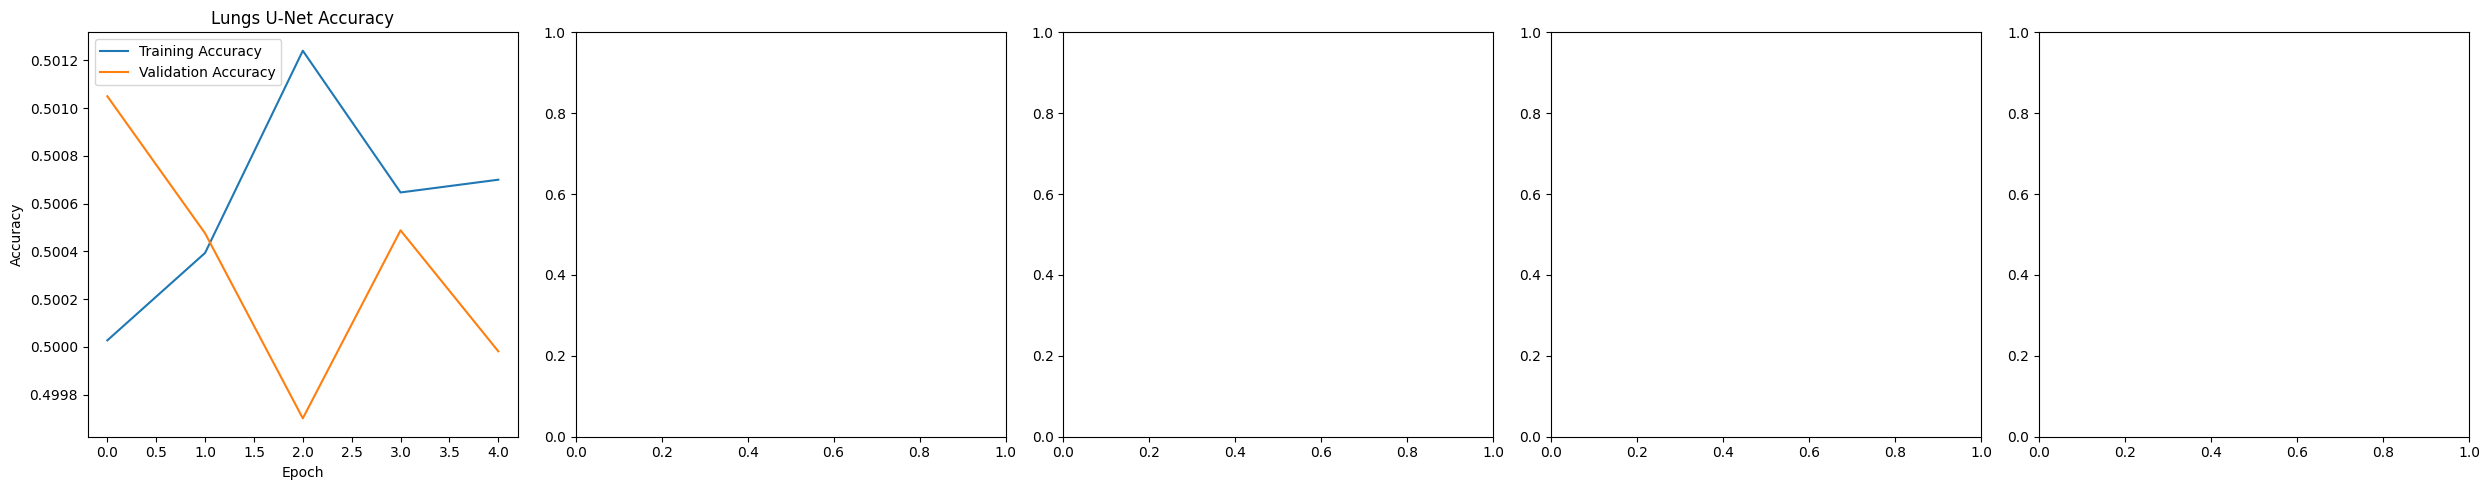


Training History Metrics for Lungs SegNet:


,accuracy,loss,val_accuracy,val_loss
0,0.500027,0.693168,0.501050,0.693143
1,0.500394,0.693154,0.500476,0.693149
2,0.501241,0.693139,0.499701,0.693168
3,0.500647,0.693149,0.500488,0.693158
4,0.500700,0.693144,0.499982,0.693157


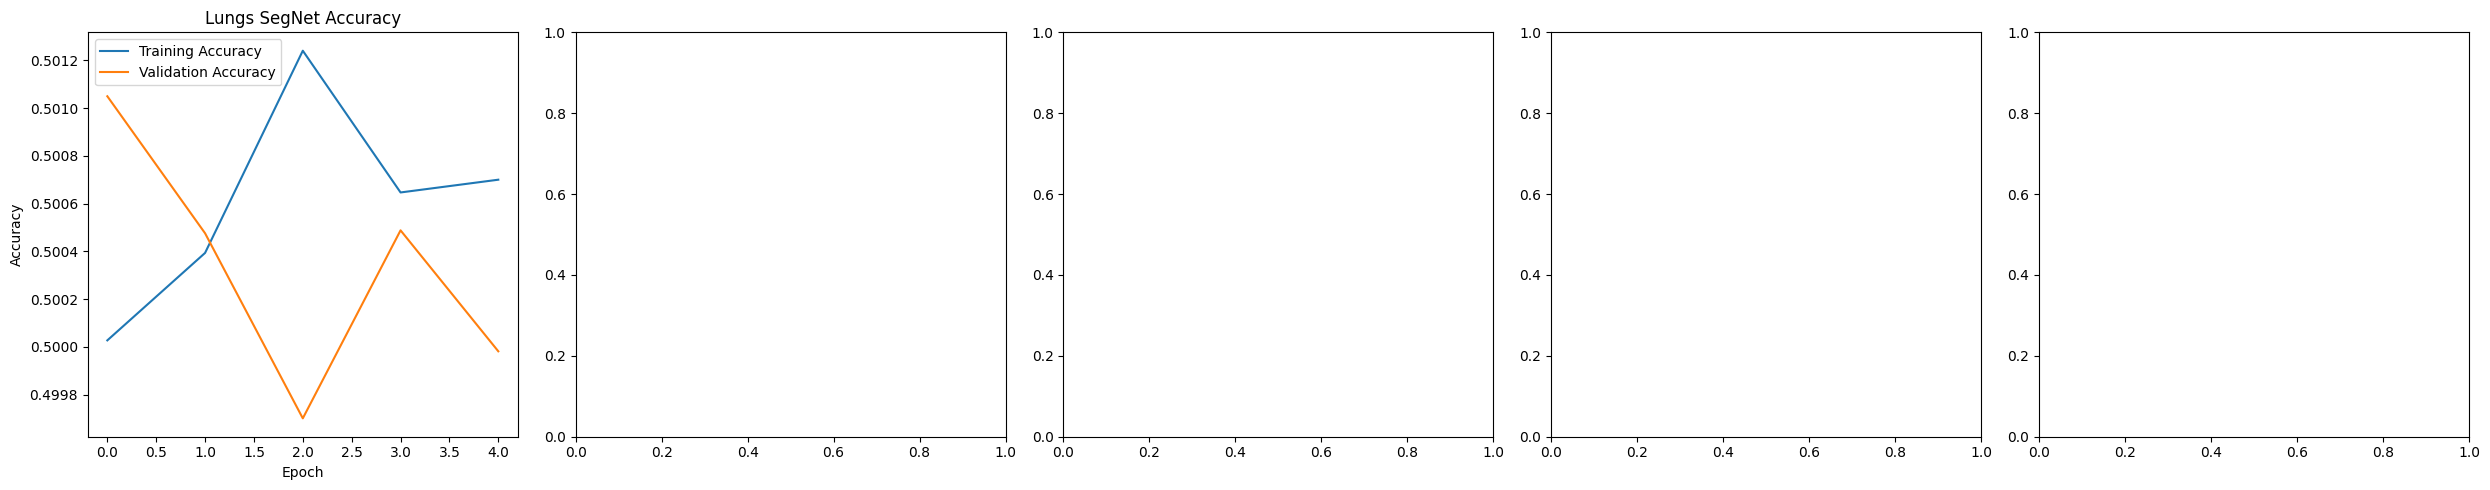

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ========================
# Function to plot training history with 5 metrics
# ========================
def plot_training_history(history, model_name="Model"):
    """
    history: Keras History object from model.fit()
    model_name: string, name of the model for plot titles
    """
    history_df = pd.DataFrame(history.history)
    print(f"\nTraining History Metrics for {model_name}:")
    display(history_df)

    # Prepare subplots
    plt.figure(figsize=(25, 5))

    metrics = [
        ('accuracy', 'Accuracy'),
        ('dice_coefficient', 'Dice Coefficient'),
        ('iou_score', 'IoU Score'),
        ('precision', 'Precision'),
        ('recall', 'Recall')
    ]

    for i, (metric_key, metric_name) in enumerate(metrics, start=1):
        plt.subplot(1, 5, i)
        if metric_key in history.history:
            plt.plot(history.history[metric_key], label=f'Training {metric_name}')
            plt.plot(history.history[f'val_{metric_key}'], label=f'Validation {metric_name}')
            plt.title(f'{model_name} {metric_name}')
            plt.xlabel('Epoch')
            plt.ylabel(metric_name)
            plt.legend()

    plt.tight_layout()
    plt.show()

# ========================
# Example Usage
# ========================
# For U-Net history
plot_training_history(history, model_name="Lungs U-Net")

# For SegNet history
plot_training_history(history, model_name="Lungs SegNet")

In [ ]:
# =======================
# Lungs SegNet
# =======================
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import jaccard_score, accuracy_score
from tqdm import tqdm  # ✅ Optional (not used but fine)

# -----------------------
# Dataset (Dummy Example)
# Replace with your data loading logic
# -----------------------
X_train = np.random.rand(50, 128, 128, 1)
y_train = np.random.randint(0, 2, (50, 128, 128, 1))
X_test  = np.random.rand(10, 128, 128, 1)
y_test  = np.random.randint(0, 2, (10, 128, 128, 1))

# -----------------------
# SegNet Model
# -----------------------
def build_segnet(input_shape=(128, 128, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Decoder
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# ✅ Build and compile
model = build_segnet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -----------------------
# Train
# -----------------------
model.fit(X_train, y_train, epochs=3, batch_size=4, validation_split=0.2)

# -----------------------
# Evaluate
# -----------------------
preds = model.predict(X_test)
preds_bin = (preds > 0.5).astype(np.uint8)

dice_scores, ious, accs = [], [], []

for i in range(len(y_test)):
    y_true_flat = y_test[i].flatten()
    y_pred_flat = preds_bin[i].flatten()

    intersection = np.sum(y_true_flat * y_pred_flat)
    dice = (2. * intersection) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-6)

    # ✅ jaccard_score expects binary labels (0 or 1)
    iou = jaccard_score(y_true_flat, y_pred_flat, zero_division=0)
    acc = accuracy_score(y_true_flat, y_pred_flat)

    dice_scores.append(dice)
    ious.append(iou)
    accs.append(acc)

print("Lungs SegNet:")
print(f"Dice: {np.mean(dice_scores):.4f}")
print(f"IoU: {np.mean(ious):.4f}")
print(f"Accuracy: {np.mean(accs):.4f}")


In [ ]:
import os
from google.colab import drive

# OPTIONAL: mount Google Drive if repo is there
# drive.mount('/content/drive')

# Change directory to your repo
%cd /content/Task-1--Medical-Images-Segmentation

# Save the current notebook into the repo folder
notebook_name = "Lungs_Seg.ipynb"  # change this to your notebook name
!cp "/content/{notebook_name}" "/content/Task-1--Medical-Images-Segmentation/{notebook_name}"

# Push changes to GitHub
!git add {notebook_name}
!git commit -m "Update {notebook_name} with latest outputs"
!git push origin main

/content/Task-1--Medical-Images-Segmentation
cp: cannot stat '/content/Lungs_Seg.ipynb': No such file or directory
fatal: pathspec 'Lungs_Seg.ipynb' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
